### Library Import

In [1]:
import sys
sys.path.append('../')
import importlib


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.preprocessing import Normalizer

from sklearn.manifold import TSNE
import umap
import os

from lsnc import lsnc
import metrics as mts
importlib.reload(lsnc)
importlib.reload(mts)

## turn off warning
import warnings
warnings.filterwarnings("ignore")

dr_measures = [
	"lc_dsc", "ls_dsc",
	"lc_btw_ch", "ls_btw_ch",   
	"stead", "cohev", 
	"trust", "conti", "mrre_lh", "mrre_hl", 
	"kl_div", "dtm", "dsc", "sil",
]
dr_measures_name = [
	"Label-Trustworthiness (DSC)", "Label-Continuity (DSC)",
	"Label-Trustworthiness (CH$_{btwn}$)", "Label-Continuity (CH$_{btwn}$)", 
	"Steadiness", "Cohesiveness", 
	"Trustworthiness", "Continuity", "MRRE [False]", "MRRE [Missing]", 
	"1 - KL-Divergence", "1 - DTM", "1 - DSC", "Silhouette",
]
type = [
	"cluster", "cluster", "cluster", "cluster", "cluster", "cluster"
	"local", "local", "local", "local",
	"global", "global", "cvm", "cvm"
]
dr_measures_line_width = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
linestyle_list = [
	"solid", "dashed", "solid", "dashed", 
	"solid", "dashed", "solid", "dashed", "solid", "dashed",
	"dotted", "dotted", "dotted", "dotted"
]
tab10 = sns.color_palette("tab10")
color_list = [
	tab10[0], tab10[0], tab10[1], tab10[1],
	tab10[2], tab10[2], tab10[3], tab10[3], tab10[4], tab10[4],
	tab10[5], tab10[6], tab10[7], tab10[8]
]

k_cand = [5, 10, 15, 20, 25]
sigma_cand = [0.01, 0.1, 1]

## Run the function definitions

In [2]:
def run_all_metrics(raw, emb, labels, k_cand, sigma_cand):
	"""
	compute all metrics
	"""
	final_results = {}

	## LS & LC (DSC)
	lsnc_obj = lsnc.LSNC(raw, emb, labels, cvm="dsc")
	results = lsnc_obj.run()
	final_results["ls_dsc"] = results["ls"]
	final_results["lc_dsc"] = results["lc"]

	## LS & LC (CH_btwn)
	lsnc_obj = lsnc.LSNC(raw, emb, labels, cvm="btw_ch")
	results = lsnc_obj.run()
	final_results["ls_btw_ch"] = results["ls"]
	final_results["lc_btw_ch"] = results["lc"]

	## Steadiness & Cohesiveness
	results = mts.stead_cohev(raw, emb)
	final_results["stead"] = results["stead"]
	final_results["cohev"] = results["cohev"]

	## Silhouette / DSC
	final_results["sil"] = mts.silhouette(emb, labels)
	final_results["dsc"] = 1 - mts.dsc(emb, labels)

	## Trust / Conti / MRRE
	trust, conti, mrre_hl, mrre_lh = 0, 0, 0, 0
	for k in k_cand:
		results = mts.trust_conti_mrre(raw, emb, k = k)
		trust += results["trust"]
		conti += results["conti"]
		mrre_hl += results["mrre_hl"]
		mrre_lh += results["mrre_lh"]
	final_results["trust"] = trust / len(k_cand)
	final_results["conti"] = conti / len(k_cand)
	final_results["mrre_hl"] = mrre_hl / len(k_cand)
	final_results["mrre_lh"] = mrre_lh / len(k_cand)

	## KL / DTM
	kl_div, dtm = 0, 0, 
	for sigma in sigma_cand:
		results = mts.kl_div_rmse_dtm(raw, emb, sigma = sigma)
		kl_div += results["kl_div"]
		dtm += results["dtm"]
	final_results["kl_div"] = 1 - kl_div / len(sigma_cand)
	final_results["dtm"] = 1 - dtm / len(sigma_cand)

	return final_results	

In [3]:
## function to plot the results using seabron (line chart)
def lineplot_results(results_list_dict, title, index_range, x_list, ax=None, invert_x_axis=False,  y_label=None, x_label=None, bbox_to_anchor=None):


	plt_inst = ax if ax is not None else plt
	sns.set_style("whitegrid")

	if (ax is None):
		plt_inst.figure(figsize=(4, 4))
	for idx in range(index_range[0], index_range[1]):
		plt_inst.plot(
			x_list, results_list_dict[dr_measures[idx]], 
			label = dr_measures_name[idx], linestyle=linestyle_list[idx], color=color_list[idx], linewidth=1.3
		)

	if (invert_x_axis):
		if ax is None:
			plt_inst.gca().invert_xaxis()
		else:
			ax.invert_xaxis()

	if (y_label != None):
		plt_inst.set_ylabel(y_label)
	if (x_label != None):
		plt_inst.set_xlabel(x_label)

	## save fig with high resolution
	if (ax is None):
		## show legend outside the plot

		plt_inst.tight_layout()
		plt_inst.savefig(f"./plot/{title}.png", dpi=300)

		plt_inst.show()

def add_legend(ax=None, bbox_to_anchor=None):
	## center legend
	if (ax is None):
		plt.legend(bbox_to_anchor=(0.5, 1.05) if bbox_to_anchor is None else bbox_to_anchor, ncol=7)
	else:
		ax.legend(bbox_to_anchor=(0.5, 1.05) if bbox_to_anchor is None else bbox_to_anchor, ncol=7)

In [4]:
def compute_metrics(raws, embs, labels, list_num, path):
	results_list_dict = {}
	for dr_measure in dr_measures:
		results_list_dict[dr_measure] = [] 

	for i in tqdm(range(list_num)):
		## if the type of raw is list,
		if isinstance(raws, list):
			raw = raws[i]
			emb = embs
		else:
			raw = raws
			emb = embs[i]

		final_results = run_all_metrics(raw, emb, labels, k_cand, sigma_cand)
		for dr_measure in dr_measures:
			results_list_dict[dr_measure].append(final_results[dr_measure])

	for dr_measure in dr_measures:
		results_list_dict[dr_measure] = np.array(results_list_dict[dr_measure])

	## Save the results
	for dr_measure in dr_measures:
		## if the path does not exists, make it
		if not os.path.exists(f"./results/{path}"):
			os.makedirs(f"./results/{path}")
		np.save(f"./results/{path}/{dr_measure}.npy", np.array(results_list_dict[dr_measure]))
	
	return results_list_dict

In [5]:
def read_results(path):
	results_list_dict = {}
	for dr_measure in dr_measures:
		results_list_dict[dr_measure] = np.load(f"./results/{path}/{dr_measure}.npy")
	return results_list_dict

In [6]:
def visualize_results(embs, labels, index=[0, 4, 8, 12, 15, 20, 24], s=1, path=None, ylen=3, invert=False):
	"""
	visualize the embeddings
	"""
	## plot the embeddings
	fig, ax = plt.subplots(1, len(index), figsize=(len(index) * 3, ylen), sharex=True, sharey=True)

	
	for i, sidx in enumerate(index):
		if invert:
			sidx = len(embs) - sidx - 1
		ax[i].scatter(embs[sidx][ :, 0], embs[sidx][ :, 1], c=labels, cmap='tab10', s=s)
		ax[i].axis('off')
	plt.tight_layout()

	if path is not None:
		plt.savefig(f"{path}.png", dpi=300)
		plt.savefig(f"{path}.pdf", dpi=300)

	plt.show()

## Experiments

### Experiment A (Randomlizing projection)
##### The purpose of this experiment is to check whether Label-SnC well captures obvious distortions 

In [7]:
raw, labels = np.load("./labeled-datasets/npy/coil20/data.npy"), np.load("./labeled-datasets/npy/coil20/label.npy")
emb_skeleton = umap.UMAP().fit_transform(raw)
## normalize emb_skeleton column by column
emb_skeleton[:, 0] = (emb_skeleton[:, 0] - np.min(emb_skeleton[:, 0])) / (np.max(emb_skeleton[:, 0]) - np.min(emb_skeleton[:, 0]))
emb_skeleton[:, 1] = (emb_skeleton[:, 1] - np.min(emb_skeleton[:, 1])) / (np.max(emb_skeleton[:, 1]) - np.min(emb_skeleton[:, 1]))
## make random project
emb_random = np.random.rand(emb_skeleton.shape[0], emb_skeleton.shape[1])

embs = []
## randomize emb_skeleton in varying magnitude (25 levels) and add it to embs
for i in range(25):
	random_rate = i / 25
	random_bool_arr = np.random.rand(emb_skeleton.shape[0], emb_skeleton.shape[1]) > random_rate
	random_bool_arr = random_bool_arr.astype(int)
	emb = emb_skeleton * random_bool_arr + emb_random * (1 - random_bool_arr)
	embs.append(emb)

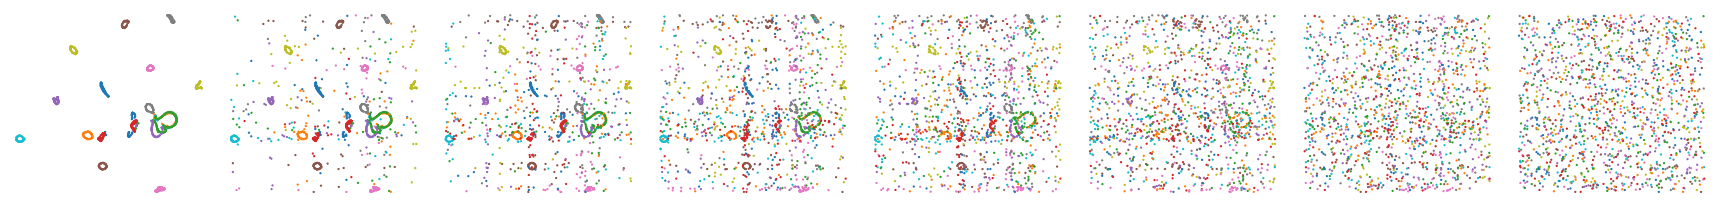

In [8]:
visualize_results(embs, labels, index=[0, 3, 6, 9, 12, 16, 20, 24], s=1.5, path="./plot_embeddings/A")

In [8]:
results_list_dict = compute_metrics(raw, embs, labels, 25, "randomizing_emb")

100%|██████████| 25/25 [05:43<00:00, 13.74s/it]


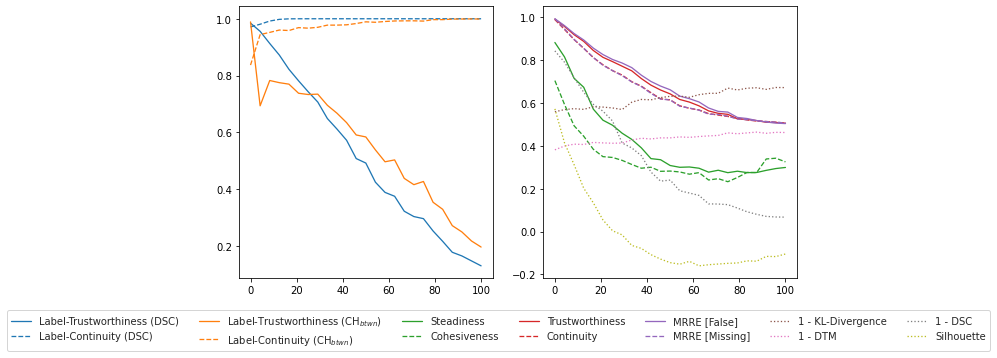

In [9]:
results_list_dict = read_results("randomizing_emb")

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
lineplot_results(results_list_dict, "randomizing_emb", index_range=(0, 4), x_list = np.linspace(0, 100, 25), ax=axs[0])
lineplot_results(results_list_dict, "randomizing_emb", index_range=(4, 14), x_list = np.linspace(0, 100, 25), ax=axs[1])
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))


## Experiment B - about compression distortion

### Experiment B-1 (6 hyperspheres and overlapping classes)

In [51]:
raw, labels = np.load("./spheres_data/data/raw.npy"), np.load("./spheres_data/data/label.npy")
embs = []
for i in range(25):
	embs.append(np.load(f"./spheres_data/data/overlapping/circle_{i}.npy"))

In [11]:
results_list_dict = compute_metrics(raw, embs, labels, 25, "overlapping_circles")

100%|██████████| 25/25 [14:28<00:00, 34.76s/it]


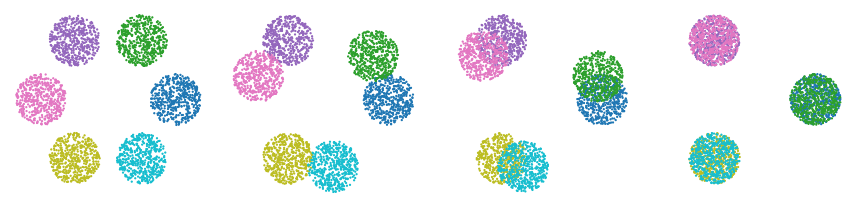

In [52]:
visualize_results(embs, labels, index=[0, 8, 16, 24], s=1.5, path="./plot_embeddings/B-1-1")

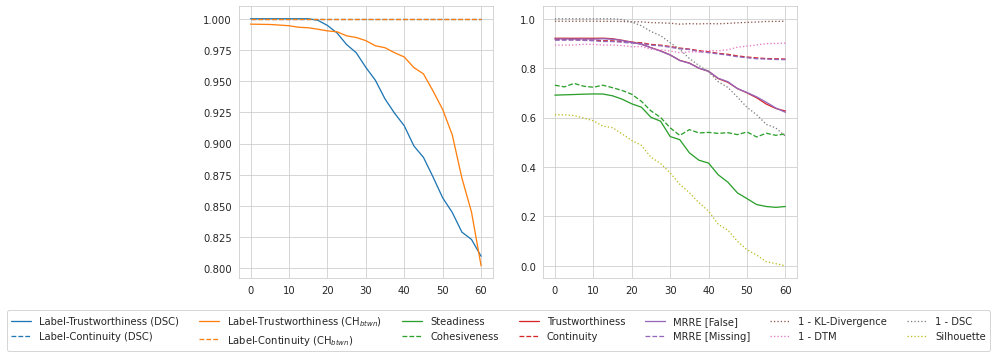

In [12]:

results_list_dict = read_results("overlapping_circles")

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
lineplot_results(results_list_dict, "overlapping_circles", index_range=(0, 4), x_list = np.linspace(0, 60, 25), ax=axs[0])
lineplot_results(results_list_dict, "overlapping_circles", index_range=(4, 14), x_list = np.linspace(0, 60, 25), ax=axs[1])
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))

### Experiment B-2 (6 hyperspheres and overlapping classes - round2)

In [49]:
raw, labels = np.load("./spheres_data/data/raw.npy"), np.load("./spheres_data/data/label.npy")
embs = []
for i in range(25):
	embs.append(np.load(f"./spheres_data/data/overlapping_more/circle_{i}.npy"))

In [14]:
results_list_dict = compute_metrics(raw, embs, labels, 25, "overlapping_circles_more")

100%|██████████| 25/25 [13:47<00:00, 33.09s/it]


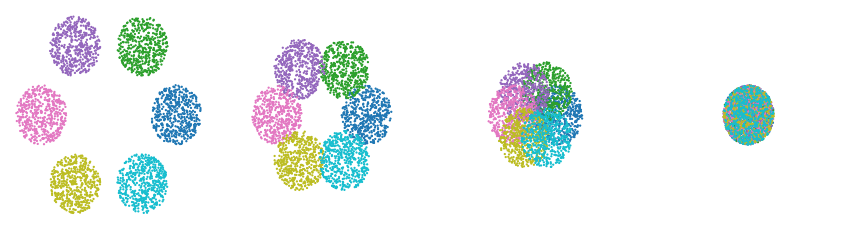

In [50]:
visualize_results(embs, labels, index=[0, 8, 16, 24], s=1.5, path="./plot_embeddings/B-1-2", ylen=3.3)

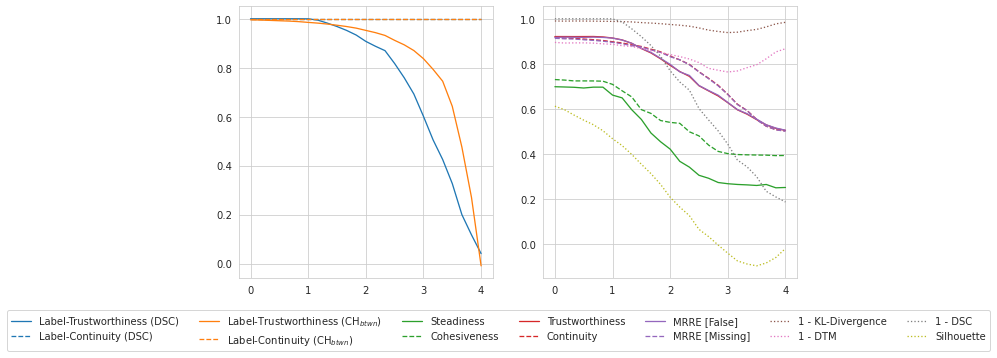

In [15]:


results_list_dict = read_results("overlapping_circles_more")

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
lineplot_results(results_list_dict, "overlapping_circles_more", index_range=(0, 4), x_list = np.linspace(0, 4, 25), ax=axs[0])
lineplot_results(results_list_dict, "overlapping_circles_more", index_range=(4, 14), x_list = np.linspace(0, 4, 25), ax=axs[1])
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))

### Experiment C (PCA Expansion test)

#### Currently with fashion-mnist dataset

In [16]:
## Dataset Generation
raw, labels = np.load("./labeled-datasets/npy/fashion_mnist/data.npy"), np.load("./labeled-datasets/npy/fashion_mnist/label.npy")
range_limit = 10
emb_pca = PCA(n_components=range_limit + 5).fit_transform(raw)

embs = []
for i in range(range_limit):
	embs.append(emb_pca[:, :i + 1])

In [17]:
## Compute metrics
results_list_dict = compute_metrics(raw, embs, labels, range_limit, "pca_expansion_digits")


100%|██████████| 10/10 [07:50<00:00, 47.02s/it]


In [100]:
embs_umap = []
index_list = [0, 1, 2, 3, 4, 6, 8, 9]
for idx, i in enumerate(index_list):
	if i == 0:
		embs_umap.append(np.concatenate([embs[i], embs[i]], axis=1))
	elif i == 1:
		embs_umap.append(embs[i])
	else:
		embs_umap.append(umap.UMAP(random_state=0, init=embs_umap[idx-1]).fit_transform(embs[i]))

for i, emb_umap in enumerate(embs_umap):
	x_max, x_min = np.max(emb_umap[:, 0]), np.min(emb_umap[:, 0])
	y_max, y_min = np.max(emb_umap[:, 1]), np.min(emb_umap[:, 1])
	emb_umap[:, 0] = (emb_umap[:, 0] - x_min) / (x_max - x_min)
	emb_umap[:, 1] = (emb_umap[:, 1] - y_min) / (y_max - y_min)



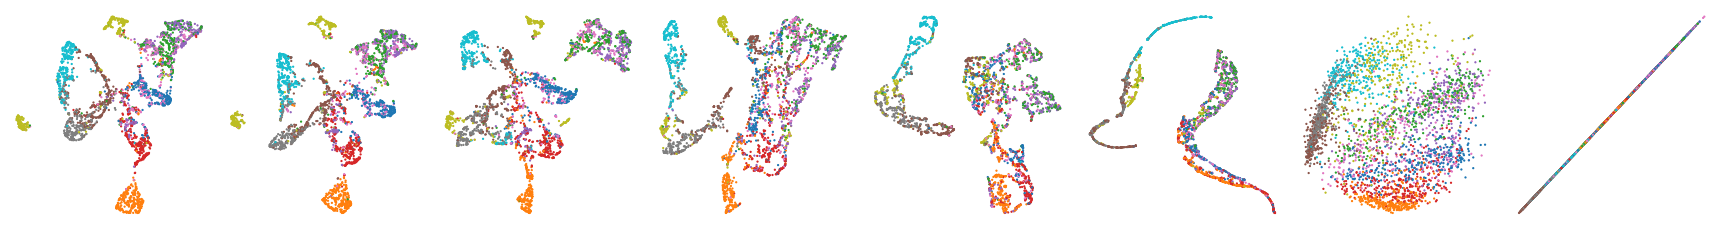

In [103]:
visualize_results(embs_umap, labels, index=range(len(index_list)), s=1.5, path="./plot_embeddings/C", ylen=3.3, invert=True)

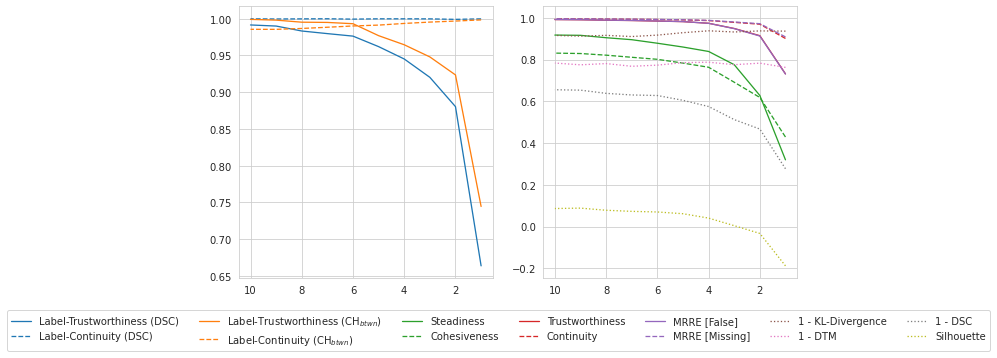

In [19]:


results_list_dict = read_results("pca_expansion_digits")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
lineplot_results(results_list_dict, "pca_expansion_digits", index_range=(0, 4), x_list = range(1, 11), ax=axs[0], invert_x_axis=True)
lineplot_results(results_list_dict, "pca_expansion_digits", index_range=(4, 14), x_list = range(1, 11), ax=axs[1], invert_x_axis=True)
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))

### Experiment D (6 circles and overlapping hd spheres)

In [53]:
emb, labels = np.load("./spheres_data/data/overlapping_raw/emb.npy"), np.load("./spheres_data/data/overlapping_raw/label.npy")
raws = []
for i in range(25):
	raws.append(np.load(f"./spheres_data/data/overlapping_raw/raw_{i}.npy"))

In [21]:
results_list_dict = compute_metrics(raws, emb, labels, 25, "overlapping_raw")

100%|██████████| 25/25 [18:39<00:00, 44.78s/it]


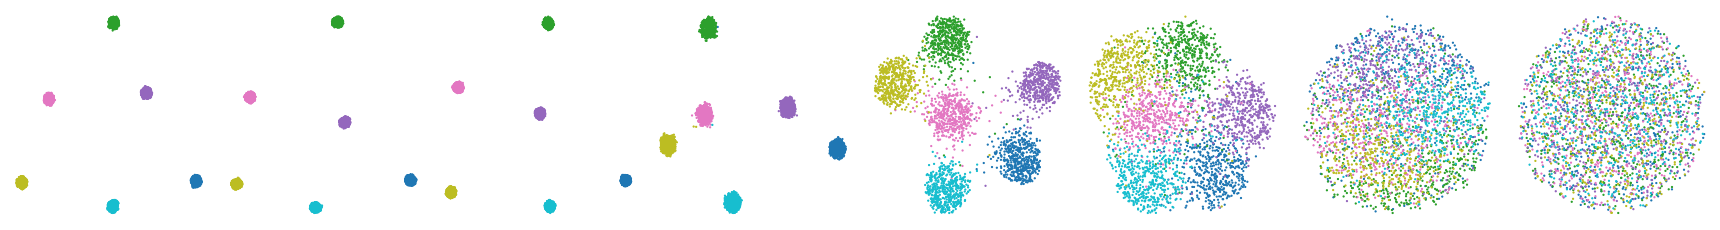

In [56]:
raws_umap = []
index_list = [0, 7, 13, 19, 20, 21, 22, 24]
for idx, i in enumerate(index_list):
	if idx == 0:
		raws_umap.append(umap.UMAP(random_state=0).fit_transform(raws[i]))
	else:
		raws_umap.append(umap.UMAP(random_state=0, init=raws_umap[idx-1]).fit_transform(raws[i]))

for i, raw_umap in enumerate(raws_umap):
	x_max, x_min = np.max(raw_umap[:, 0]), np.min(raw_umap[:, 0])
	y_max, y_min = np.max(raw_umap[:, 1]), np.min(raw_umap[:, 1])
	raw_umap[:, 0] = (raw_umap[:, 0] - x_min) / (x_max - x_min)
	raw_umap[:, 1] = (raw_umap[:, 1] - y_min) / (y_max - y_min)


visualize_results(raws_umap, labels, index=range(len(index_list)), s=1.5, path="./plot_embeddings/D", ylen=3.3)

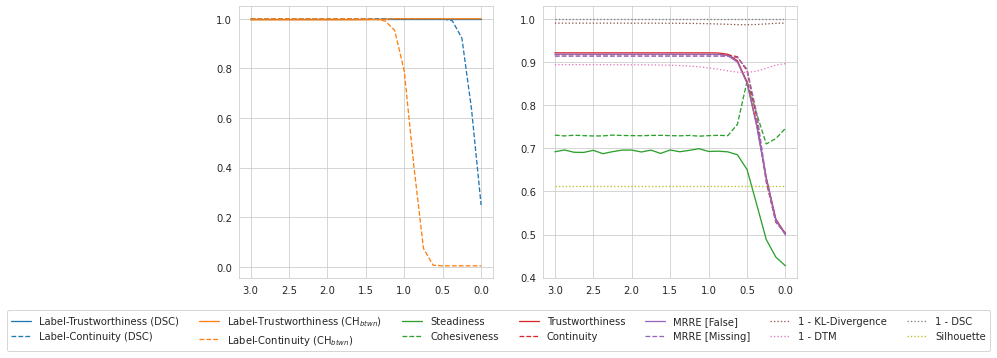

In [22]:

results_list_dict = read_results("overlapping_raw")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
lineplot_results(results_list_dict, "overlapping_raw", index_range=(0, 4), x_list = np.linspace(3, 0, 25), ax=axs[0], invert_x_axis=True)
lineplot_results(results_list_dict, "overlapping_raw", index_range=(4, 14), x_list = np.linspace(3, 0, 25), ax=axs[1], invert_x_axis=True)
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))




### Experiment E (2D UMAP and high dimensional as PCA projections with decreasing number of PC

#### Currently With fashion mnist dataset

In [23]:
## Dataset Generation (with digits data)
raw_orig, labels = np.load("./labeled-datasets/npy/fashion_mnist/data.npy"), np.load("./labeled-datasets/npy/fashion_mnist/label.npy")
emb = np.load("./labeled-datasets_embedding/fashion_mnist/umap.npy")

component_interval = 10
raws = []
raw_pca = PCA(n_components=300).fit_transform(raw_orig)
for i in range(10):
	raw = raw_pca[:, i: i + component_interval]
	raws.append(raw)


In [24]:
## compute the metrics of the original data and save
results_list_dict = compute_metrics(raws, emb, labels, 10, "pca_decreasing_digits")

100%|██████████| 10/10 [03:08<00:00, 18.88s/it]


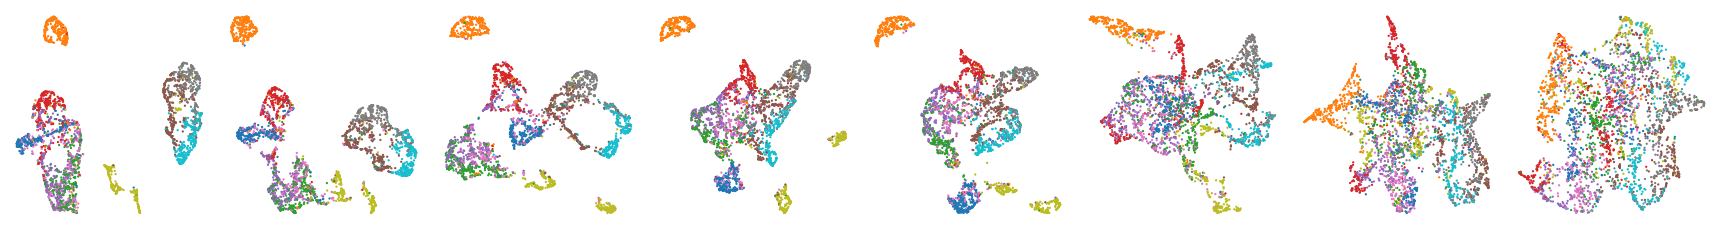

In [129]:
raws_umap = []
index_list = [0, 1, 2, 3, 4, 6, 8, 9]
for idx, i in enumerate(index_list):
	if idx == 0:
		raws_umap.append(umap.UMAP(random_state=0).fit_transform(raws[i]))
	else:
		raws_umap.append(umap.UMAP(random_state=0, init=raws_umap[idx-1]).fit_transform(raws[i]))

for i, raw_umap in enumerate(raws_umap):
	x_max, x_min = np.max(raw_umap[:, 0]), np.min(raw_umap[:, 0])
	y_max, y_min = np.max(raw_umap[:, 1]), np.min(raw_umap[:, 1])
	raw_umap[:, 0] = (raw_umap[:, 0] - x_min) / (x_max - x_min)
	raw_umap[:, 1] = (raw_umap[:, 1] - y_min) / (y_max - y_min)

visualize_results(raws_umap, labels, index=range(len(index_list)), s=1.5, path="./plot_embeddings/E", ylen=3.3)

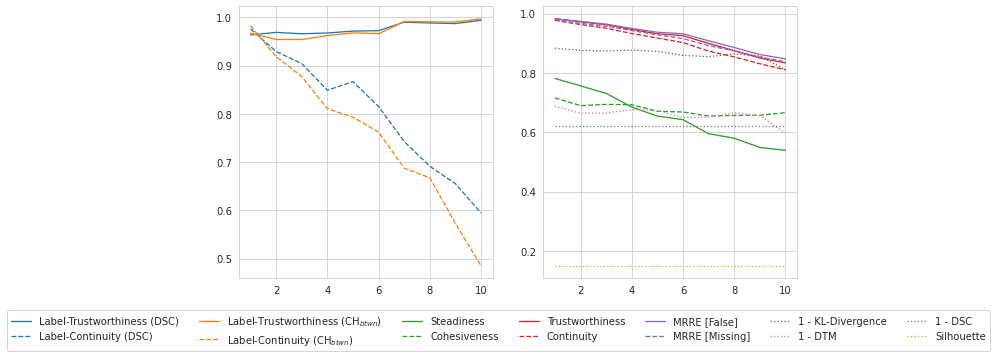

In [25]:


results_list_dict = read_results("pca_decreasing_digits")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
lineplot_results(results_list_dict, "pca_decreasing_digits", index_range=(0, 4), x_list = range(1, 11), ax=axs[0])
lineplot_results(results_list_dict, "pca_decreasing_digits", index_range=(4, 14), x_list = range(1, 11), ax=axs[1])
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))



### Visualizing Results

In [26]:
## read
tests = ["randomizing_emb", "overlapping_circles", "overlapping_circles_more", "pca_expansion_digits", "overlapping_raw", "pca_decreasing_digits"]
x_lists = [np.linspace(0, 100, 25), np.linspace(60, 0, 25), np.linspace(4, 0, 25), range(1, 11), np.linspace(4, 0, 25), range(1,11), ]
y_labels = ["score", None, None, None, None, None]
x_labels = ["Randomization rate","angle btw two circles", "dist from a center", "rank of PC", "var btw hyperspheres", "rank of PC", ]
inverts = [False, True, True, True, True, False,]


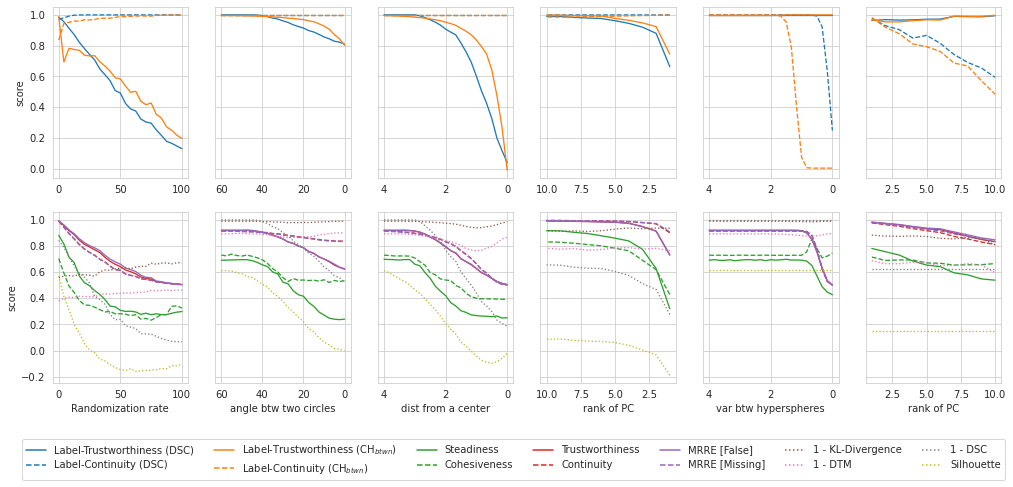

In [48]:
## plot for plots in the single figure
from matplotlib.lines import Line2D

fig, axs = plt.subplots(2, 6, figsize=(17, 9), sharey="row")

for i, test in enumerate(tests):
	results_list_dict = read_results(test)
	lineplot_results(results_list_dict, test,  index_range=(0, 4), x_list = x_lists[i], invert_x_axis=inverts[i], ax = axs[0, i], y_label=y_labels[i], x_label=None)
	lineplot_results(results_list_dict, test,  index_range=(4, 14), x_list = x_lists[i], invert_x_axis=inverts[i], ax = axs[1, i], y_label=y_labels[i], x_label=x_labels[i])

## create legend based on dr_measures_name, linestyle, color...
legends_elements = []
for i, name in enumerate(dr_measures_name):
	legends_elements.append(Line2D([0], [0], color=color_list[i], lw=1.5, label=name, linestyle=linestyle_list[i]))

## add legend
axs[1, 3].legend(handles=legends_elements, loc='upper center', bbox_to_anchor=(-0.2, -0.3), ncol=7, fontsize=10)


plt.subplots_adjust(bottom=0.3)
plt.savefig(f"./plot/summarize.png", dpi=300)
plt.savefig(f"./plot/summarize.pdf", dpi=300)


### For appendix: reproduction test for B-2

In [45]:
datasets = [
	"weather", "optical_recognition_of_handwritten_digits", 
	"mnist64", "har", "coil20",
	"olivetti_faces", "cnae9", 
	"student_grade", 
]
dataset_name = [
	"Weather", "Optical Recognition", "Mnist 64", "HAR", "Coil-20",
	"Olivetti Faces", "CNAE-9",
	"Student Grade", 
]

In [41]:
for dataset in datasets:
	raw, labels = np.load(f"./labeled-datasets/npy/{dataset}/data.npy"), np.load(f"./labeled-datasets/npy/{dataset}/label.npy")
	range_limit = 10
	emb_pca = PCA(n_components=range_limit + 5).fit_transform(raw)
	embs = []
	for i in range(range_limit):
		embs.append(emb_pca[:, :i+1]) 
	

	results_list_dict = compute_metrics(raw, embs, labels, range_limit, f"pca_expansion_{dataset}")


100%|██████████| 10/10 [02:36<00:00, 15.69s/it]


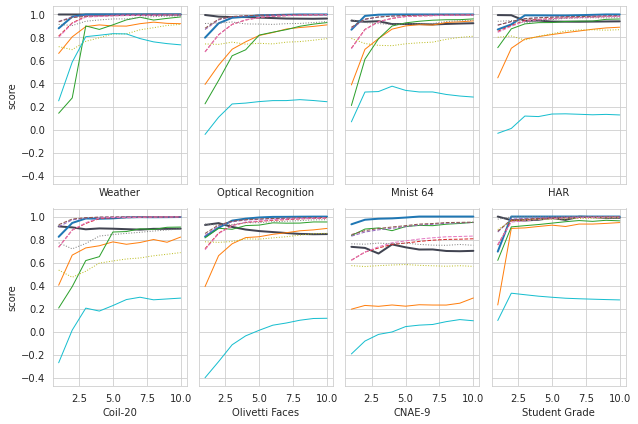

In [46]:
fig, axs = plt.subplots(2, 4, figsize=(9, 6), sharey=True, sharex=True)

for i, dataset in enumerate(datasets):
	results = read_results(f"pca_expansion_{dataset}")
	lineplot_results(
		results, dataset, 
		x_list = None, invert_x_axis=False,
		ax = axs[i // 4, i % 4],
		add_legend = False,
		y_label = "score" if i % 4 == 0 else None,
		x_label = dataset_name[i]
	)


plt.tight_layout()
plt.savefig("./plot/b2_reproduce.png", dpi=300)
plt.savefig("./plot/b2_reproduce.pdf", dpi=300)

### For appendix: reproduction test for C-2

In [43]:
### For appendix: reproduction test for B-2
for dataset in datasets:
	raw_orig, labels = np.load(f"./labeled-datasets/npy/{dataset}/data.npy"), np.load(f"./labeled-datasets/npy/{dataset}/label.npy")
	emb = np.load(f"./labeled-datasets_embedding/{dataset}/umap.npy")
	component_interval = 10
	range_limit = 10
	raws = []
	raw_pca = PCA(n_components=22).fit_transform(raw_orig)
	for i in range(range_limit):
		raws.append(raw_pca[:, i: i + component_interval])
	

	results_list_dict = compute_metrics(raws, emb, labels, range_limit, f"pca_decreasing_{dataset}")




100%|██████████| 10/10 [01:39<00:00,  9.95s/it]


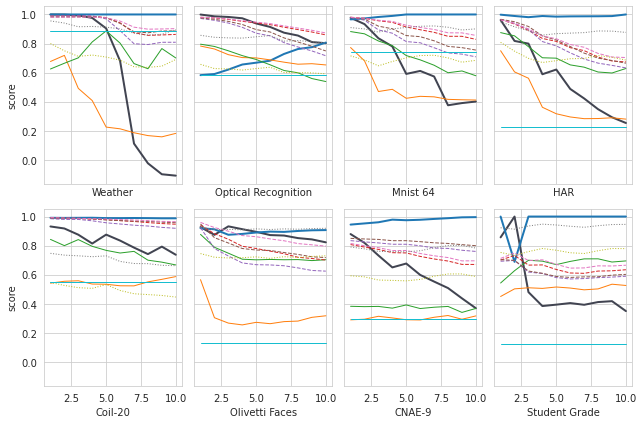

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(9, 6), sharey=True, sharex=True)

for i, dataset in enumerate(datasets):
	results = read_results(f"pca_decreasing_{dataset}")
	lineplot_results(
		results, dataset, 
		x_list = None, invert_x_axis=False,
		ax = axs[i // 4, i % 4],
		add_legend = False,
		y_label = "score" if i % 4 == 0 else None,
		x_label = dataset_name[i]
	)


plt.tight_layout()
plt.savefig("./plot/c2_reproduce.png", dpi=300)
plt.savefig("./plot/c2_reproduce.pdf", dpi=300)